In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
    

C:\Users\kaczm\AppData\Local\Temp\ipykernel_1180\2359488012.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion


TensorFlow Version: 2.8.0
Default GPU Device: /device:GPU:0


## sprawdzenie czy dane istnieją w danym folderze i pobranie ich listy nazw

In [2]:
import os
raw = os.listdir('Data/Syntetic/raw')
import random
random.Random(3143).shuffle(raw)



Train = raw.copy()[0:100]

Valid = raw.copy()[100:120]

Test = raw.copy()[120:]

random.Random().shuffle(Train)
random.Random().shuffle(Valid)

print(len(Train))

100


## tworzenie generatora para() (i później valid_para()) do wczytywania danych do sieci.

Wczytywane zostają dane .nii, następnie podlegają one preprocesingowi. Finalnie zwracany jest np.ndarray.

In [3]:
from tensorflow import image
import os
#wczytanie konkretnego pliku
import nibabel as nib
from matplotlib import pyplot as plt

import SimpleITK as sitk
import numpy as np

px = 256

def kwadratuj(arr,a,b):
    #funkcja typowo dla tych danych, nie ogólna!
    
    
    arr1 = tf.image.resize(
    arr, [a,b], method=image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=False,
    antialias=False, name=None)

    
    return arr1
def para():
    stop = 100
    raw = Train

    random.Random().shuffle(raw)
    a=1
    while a < stop:
        t1_fn = 'Data/Syntetic/raw/' + raw[a]
        t2_fn = 'Data/Syntetic/seg/' + raw[a]

        # Read the .nii image containing the volume with SimpleITK:
        sitk_t1 = sitk.ReadImage(t1_fn)
        sitk_t2 = sitk.ReadImage(t2_fn)

        # and access the numpy array:
        t1 = sitk.GetArrayFromImage(sitk_t1)
        t2 = sitk.GetArrayFromImage(sitk_t2)
        t1 = t1 / 255
        
        
        t1 = t1.reshape(600,304,325,1)
        t2 = t2.reshape(600,304,325,1)

        t1 = t1[:,8:288+8,18:288+18,:]
        t2 = t2[:,8:288+8,18:288+18,:]

        t1 = tf.dtypes.cast(t1,tf.float32)
        t2 = tf.dtypes.cast(t2,tf.float32)
        
        t2 = tf.keras.utils.to_categorical(t2,2)
        
        '''
        temp1 = np.zeros((600,320,320))
        temp2 = np.zeros((600,320,320))
        
        temp1[:,0:304,0:325] = t1[:,0:304,0:320]
        temp2[:,0:304,0:325] = t2[:,0:304,0:320]
        temp1 = temp1.reshape(600,320,320,1)
        temp2 = temp2.reshape(600,320,320,1)
        '''
        
        
        for i in range(600):
            
            temp1 = t1[i,:,:,0:1]
            temp2 = t2[i,:,:,0:2]
           
            
            yield (temp1,temp2)
        a+=1
        del(t1)
        del(t2)
        del(temp1)
        del(temp2)
        
#a = para()
#for i in a:
#    i = tf.data.Dataset.from_tensor_slices(i)
#    print(i)

batch_size=8
    
dataset = tf.data.Dataset.from_generator(
     para,
     (tf.float32,tf.float32), 
    (tf.TensorShape([288,288,1]), tf.TensorShape([288,288,2])))
dataset = dataset.repeat(101).batch(batch_size)#.shuffle(1000,  reshuffle_each_iteration=True)


In [4]:
print(dataset)
print("TF dataset działa, dane dostępne")


<BatchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 2), dtype=tf.float32, name=None))>


In [5]:
#wczytanie konkretnego pliku
import nibabel as nib
from matplotlib import pyplot as plt

#136 examples of size (325 × 304 × 600).
patiens_test = 200
patiens_valid = 20

px1 = 325
px2  = 304
P = 1*17*600
T=5*600

def valid_para():
    stop = 20
    raw = Valid
    import random
    random.Random().shuffle(raw)
    #print(raw)
    for patient in raw:
        t1_fn = 'Data/Syntetic/raw/' + patient
        t2_fn = 'Data/Syntetic/seg/' + patient
        #print('a = ',a)

        # Read the .nii image containing the volume with SimpleITK:
        sitk_t1 = sitk.ReadImage(t1_fn)
        sitk_t2 = sitk.ReadImage(t2_fn)

        # and access the numpy array:
        t1 = sitk.GetArrayFromImage(sitk_t1)
        t2 = sitk.GetArrayFromImage(sitk_t2)
        t1 = t1 / 255
        
        
        t1 = t1.reshape(600,304,325,1)
        t2 = t2.reshape(600,304,325,1)

        t1 = t1[:,8:288+8,18:288+18,:]
        t2 = t2[:,8:288+8,18:288+18,:]

        t1 = tf.dtypes.cast(t1,tf.float32)
        t2 = tf.dtypes.cast(t2,tf.float32)
        
        t2 = tf.keras.utils.to_categorical(t2,2)
        
        '''
        temp1 = np.zeros((600,320,320))
        temp2 = np.zeros((600,320,320))
        
        temp1[:,0:304,0:325] = t1[:,0:304,0:320]
        temp2[:,0:304,0:325] = t2[:,0:304,0:320]
        temp1 = temp1.reshape(600,320,320,1)
        temp2 = temp2.reshape(600,320,320,1)
        '''
        
        
        for i in range(600):
            
            temp1 = t1[i,:,:,0:1]
            temp2 = t2[i,:,:,0:2]
           
            
            yield (temp1,temp2)
        del(t1)
        del(t2)
        del(temp1)
        del(temp2)

    
valid_gen = tf.data.Dataset.from_generator(
     valid_para,
     (tf.float32,tf.float32), 
    (tf.TensorShape([288,288,1]), tf.TensorShape([288,288,2])))
valid_gen = valid_gen.repeat(100).batch(batch_size)#.shuffle(1000,  reshuffle_each_iteration=True)



In [6]:
print(valid_gen)

<BatchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 2), dtype=tf.float32, name=None))>


## budowanie sieci 

Stworzony zostaje U-net 2D zgodnie z modelem opisanym w pracy.


In [7]:
#budowanie sieci
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TerminateOnNaN
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(2, (1,1), padding="same", activation="softmax")(uconv1)
    
    return output_layer
px = 288
input_layer = Input((px, px, 1))
output_layer = build_model(input_layer, 64)

In [8]:
model = Model(input_layer, output_layer)

In [9]:
import tensorflow.keras.backend as K
def dice(y_true, y_pred):
    smooth = 1
    intersection = K.sum(y_true * y_pred, axis=list(range(1, K.ndim(y_true))))
    union = K.sum(y_true, axis=list(range(1, K.ndim(y_true)))) + K.sum(y_pred, axis=list(range(1, K.ndim(y_true))))
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision = tf.keras.metrics.Precision(
    thresholds=0.5, class_id=1)
recall = tf.keras.metrics.Recall(
    thresholds=0.5, class_id=1)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[precision,recall])
model.summary(positions=[.33, .66, .78, 1.])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_1 (InputLayer)           [(None, 288, 288, 1)]           0           []                    
                                                                                                  
 conv2d (Conv2D)                (None, 288, 288, 64)            640         ['input_1[0][0]']     
                                                                                                  
 conv2d_1 (Conv2D)              (None, 288, 288, 64)            36928       ['conv2d[0][0]']      
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 144, 144, 64)            0           ['conv2d_1[0][0]']    
                                                                                              

                                                                                                  
 conv2d_15 (Conv2D)             (None, 144, 144, 128)           147584      ['conv2d_14[0][0]']   
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 288, 288, 64)           73792       ['conv2d_15[0][0]']   
 spose)                                                                                           
                                                                                                  
 concatenate_3 (Concatenate)    (None, 288, 288, 128)           0           ['conv2d_transpose_3[0
                                                                            ][0]',                
                                                                             'conv2d_1[0][0]']    
                                                                                                  
 dropout_7

In [10]:
#komórka do wczytywania checkpointu

#checkpoint_path = "model-Unet2D-od0-poprawkach.h5"
#model.load_weights(checkpoint_path)
print('cheackpoint wczytany')

cheackpoint wczytany


In [11]:


callbacks = [
    #EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=1),
    ModelCheckpoint("model-Unet2D-od0-poprawkach.h5", verbose=1, save_best_only=True, save_weights_only=True),
    TerminateOnNaN()
]

#10 epok przeszło,teraz kolejen 5
epochs = 3
steps_per_epoch = (600*100) / batch_size #ilość kawałków x plików / batch_size* z dokładnościa do dziielnia przez 32

validations_steps = (600*20) / batch_size #ilość kawałków x plików /batch_size
history = model.fit( dataset, validation_data=valid_gen, callbacks=callbacks, initial_epoch=0,
                    epochs=epochs, validation_steps = validations_steps, steps_per_epoch=steps_per_epoch
                    )

Epoch 1/3
7500/7500 [==============================] - ETA: 0s - loss: 0.0014 - precision: 0.9975 - recall: 0.9897
Epoch 1: val_loss improved from inf to 0.00113, saving model to model-Unet2D-od0-poprawkach.h5
7500/7500 [==============================] - 2094s 278ms/step - loss: 0.0014 - precision: 0.9975 - recall: 0.9897 - val_loss: 0.0011 - val_precision: 0.9703 - val_recall: 0.9996 - lr: 0.0010
Epoch 2/3
7500/7500 [==============================] - ETA: 0s - loss: 0.0058 - precision: 0.9915 - recall: 0.9924
Epoch 2: val_loss improved from 0.00113 to 0.00009, saving model to model-Unet2D-od0-poprawkach.h5
7500/7500 [==============================] - 2074s 276ms/step - loss: 0.0058 - precision: 0.9915 - recall: 0.9924 - val_loss: 9.0685e-05 - val_precision: 0.9995 - val_recall: 0.9994 - lr: 0.0010
Epoch 3/3
7500/7500 [==============================] - ETA: 0s - loss: 9.1135e-05 - precision: 0.9993 - recall: 0.9994
Epoch 3: val_loss improved from 0.00009 to 0.00007, saving model to mod

In [ ]:
#walidacja
                    
validations_steps = (600*20) / batch_size #ilość kawałków x plików /batch_size
valuated = model.evaluate(
                x=valid_gen, verbose=1, sample_weight=None, steps=validations_steps,
                callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=True
                )




In [ ]:
print(f'valuated model: loss: {valuated[0]}, precision: {valuated[1]}, recall: {valuated[2]} ' )

## Przetestowanie predykcji

In [17]:

raw = os.listdir('Data/Syntetic/raw')
a = 118
t1_fn = 'Data/Syntetic/raw/' + raw[a]
t2_fn = 'Data/Syntetic/seg/' + raw[a]

# Read the .nii image containing the volume with SimpleITK:
sitk_t1 = sitk.ReadImage(t1_fn)
sitk_t2 = sitk.ReadImage(t2_fn)

# and access the numpy array:
t1 = sitk.GetArrayFromImage(sitk_t1)
t2 = sitk.GetArrayFromImage(sitk_t2)
t1 = t1 / 255


t1 = t1.reshape(600,304,325,1)
t2 = t2.reshape(600,304,325,1)

t1 = t1[:,8:288+8,18:288+18,:]
t2 = t2[:,8:288+8,18:288+18,:]

t1 = tf.dtypes.cast(t1,tf.float32)
t2 = tf.dtypes.cast(t2,tf.float32)

t2 = tf.keras.utils.to_categorical(t2,2)

'''
temp1 = np.zeros((600,320,320))
temp2 = np.zeros((600,320,320))

temp1[:,0:304,0:325] = t1[:,0:304,0:320]
temp2[:,0:304,0:325] = t2[:,0:304,0:320]
temp1 = temp1.reshape(600,320,320,1)
temp2 = temp2.reshape(600,320,320,1)
'''


print(t1.shape)
print(t2.shape)

(600, 288, 288, 1)
(600, 288, 288, 2)


In [18]:
Preds = np.zeros((600,288,288,2))
Preds[:,:,:,0:2] = model.predict(t1[:,:,:,0:1])
    

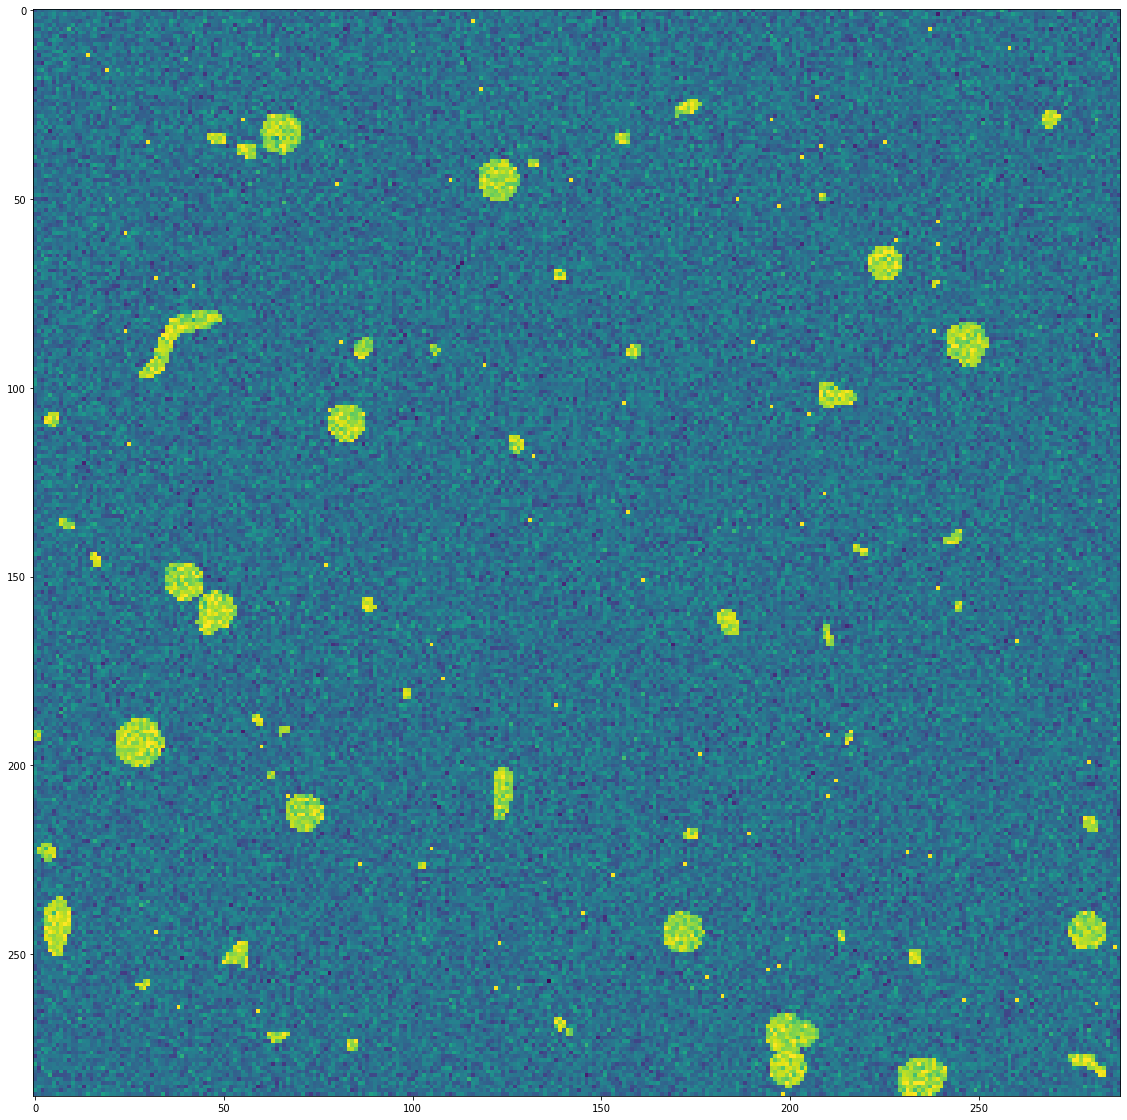

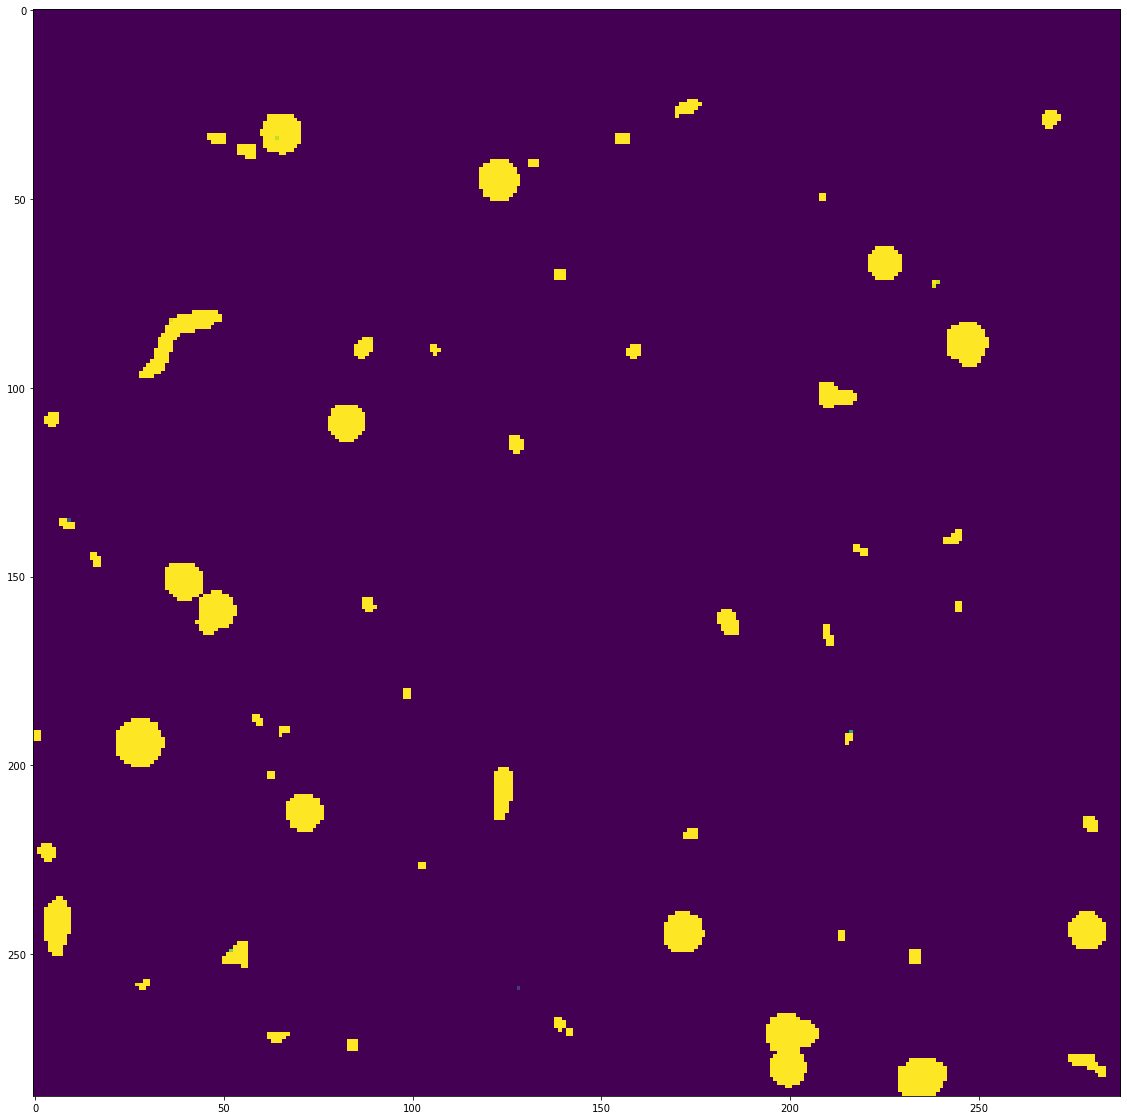

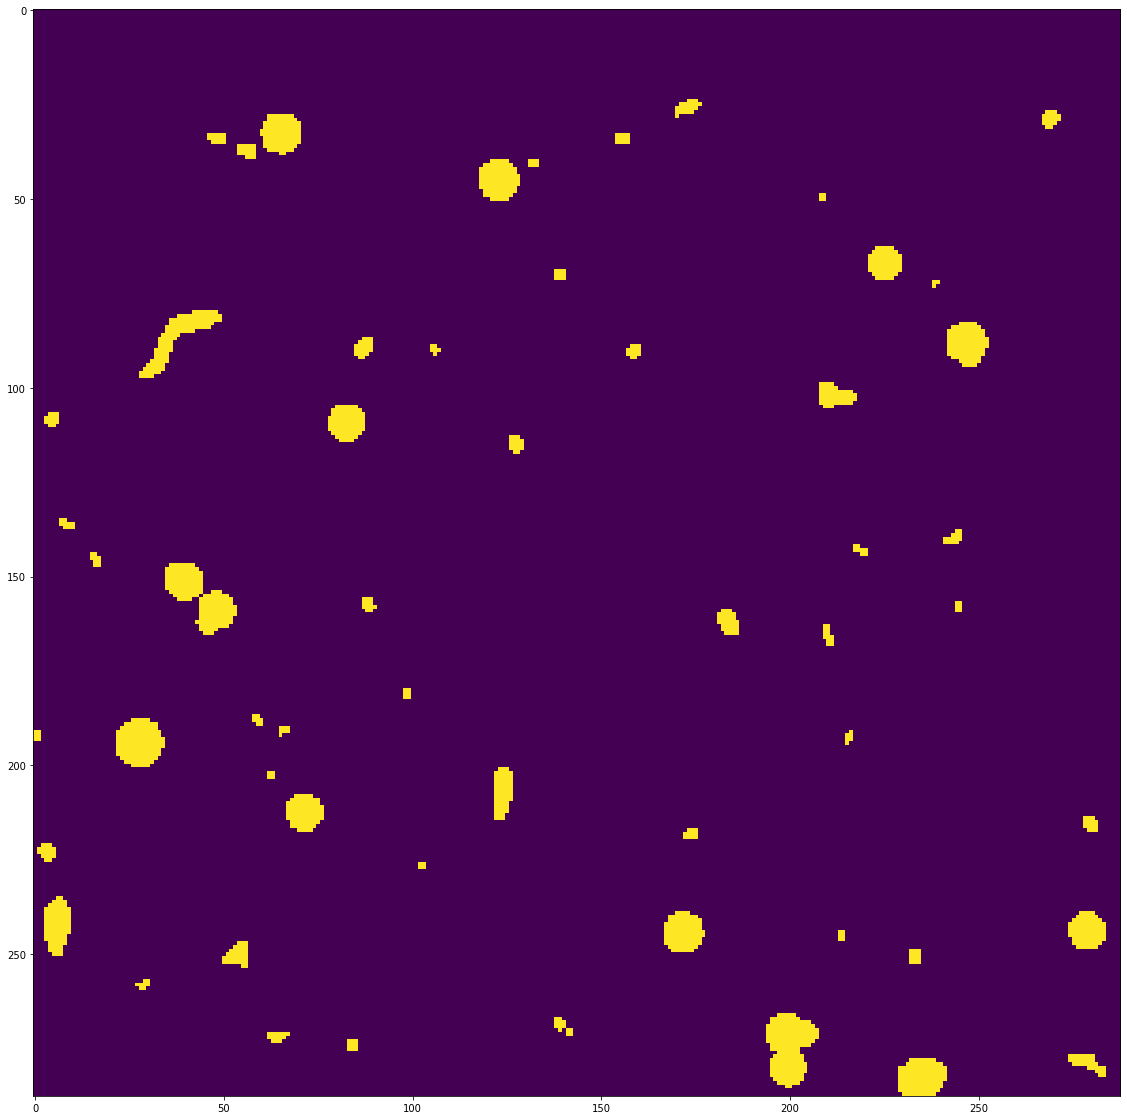

In [19]:
plt.figure(figsize=(20,20))

plt.imshow(t1[35,:,:,0])
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(Preds[35,:,:,1])
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(t2[35,:,:,1])

